In [1]:
### load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

import wntr
import wntr_utils

In [2]:
week_1 = pd.read_csv('../ICS_topologies/minitown_topology_dataset_generation/week_1/physical_process.csv')
week_2 = pd.read_csv('../ICS_topologies/minitown_topology_dataset_generation/week_2/physical_process.csv')

# Testing our pattern
We use the variable week_index to take each weekly pattern into the simulations

In [3]:
# Create a water network model
inp_file = 'minitown_map.inp'
results_list = []
df_new = pd.read_csv('trial_30weeks_version2.csv', index_col=0)
### load new demands
d_max = 0.0125
constant = 0.00
scaler = MinMaxScaler(feature_range=(0, d_max))
temp = scaler.fit_transform(df_new.values.reshape(-1,1))
df_scaled = pd.DataFrame(columns = df_new.columns, data = temp.reshape(df_new.shape))+constant

meh=[]
# Simulate 30 times, with different demand patterns
last_level = 3
for week_index in range(0,30):
    wn = wntr.network.WaterNetworkModel(inp_file)
    tank = wn.get_node('TANK')
    tank.init_level = last_level

    df_check = wntr_utils.get_demand_patterns_from_nodes(wn)
    df_old = wntr_utils.get_demand_patterns_from_nodes(wn)
    
    # Substitute new demands
    juncs = df_old.columns

    juncs = juncs[(df_old.sum()>0).values].tolist() # these are the demand nodes
    assert(len(juncs)==df_scaled.shape[1]) # check if they match columns in new demands
    d_juncs = dict(zip(juncs,df_scaled.columns)) # match each demand node with new demand
    
    # remove old patterns (this seems to work, can be done better to speed it up)
    for p_name in wn.pattern_name_list:
        for j_name in wn.junction_name_list:
            try:
                wn._pattern_reg.remove_usage(p_name,(wn.name, j_name))
            except:
                pass
                # print(f'Junction {j_name} not using pattern {p_name}')  
    
    new_pat={}
    new_pat['pat1'] = df_scaled['pat1'].values[168*week_index:168*(week_index+1)-1]
    new_pat['pat2'] = df_scaled['pat2'].values[168*week_index:168*(week_index+1)-1]
    new_pat['pat3'] = df_scaled['pat3'].values[168*week_index:168*(week_index+1)-1]
    new_pat['pat4'] = df_scaled['pat4'].values[168*week_index:168*(week_index+1)-1]

    # Add the weekly pattern
    for name in df_scaled.columns:
        wn.add_pattern(name=name, pattern=new_pat[name])        
        
    # We leave this loop as it is
    for name in juncs:
        junc = wn.get_node(name)
        junc.add_demand(1,d_juncs[name]) 
    
    for name in juncs:
        junc = wn.get_node(name)
        junc.add_demand(1,d_juncs[name])     
    
    sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
    results = sim.run_sim()
    result_dict=dict.fromkeys(['name','results'])
    result_dict['name'] = "Week_" + str(week_index)
    result_dict['results'] = results
    results_list.append(result_dict)    
    week_index+=1
    
    # update tank level
    last_level = 2+np.random.rand()*2

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "minitown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


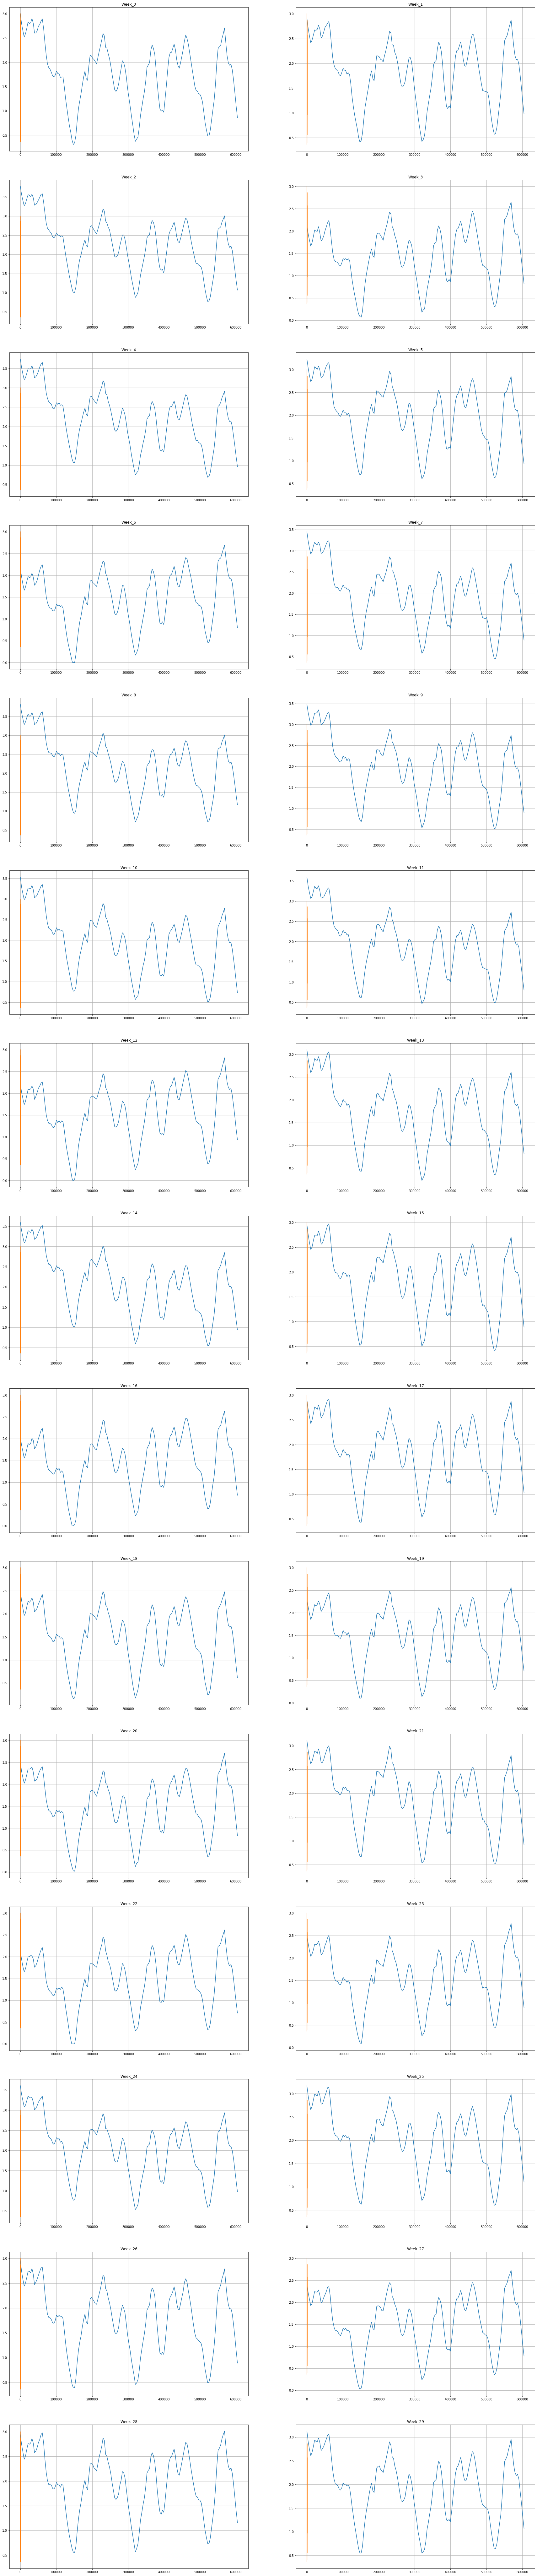

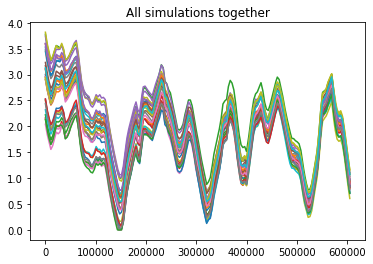

In [5]:
nr = 15 
nc = 2

f, ax = plt.subplots(nr,nc,figsize=(30,150))
week_index = 0

for row_index in range(0,15):
    for col_index in range(0,2):    
        ax[row_index][col_index].plot(results_list[week_index]['results'].node['pressure']['TANK'])
        ax[row_index][col_index].plot(week_1["TANK_LEVEL"])
        ax[row_index][col_index].set_title( results_list[week_index]['name'] )        
        ax[row_index][col_index].grid()
        week_index += 1
        
    
f, ax_2 = plt.subplots(1,1)
for week_index in range(0,30):
    ax_2.plot(results_list[week_index]['results'].node['pressure']['TANK'])
    ax_2.set_title("All simulations together")
    
